With this code, I was able to achieve a private score of 0.86849 without performing feature engineering. My focus was primarily on refining the modeling process itself. The key approach here was customizing each model individually and then combining them using a soft VotingClassifier.

One significant factor that greatly aided my efforts was manually calculating the accuracy of the ensemble's voting. I haven't yet discovered a method to obtain the individual scores of each model after fitting the VotingClassifier. Consequently, when I wanted to experiment with different weights and other models, I had to retrain the ensemble (which can take approximately 1 hour). To address this issue, I manually computed the accuracy, saving a substantial amount of time and computational resources in the process.


Feel free to try it on your own and comment your thoughts/point any mistakes i've made. The main goal is to learn

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.exceptions import DataConversionWarning
from pandas import set_option


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Suprimir o aviso de DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.resetwarnings()

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/submission/submission.csv
/kaggle/input/GiveMeSomeCredit/Data Dictionary.xls
/kaggle/input/GiveMeSomeCredit/cs-training.csv
/kaggle/input/GiveMeSomeCredit/sampleEntry.csv
/kaggle/input/GiveMeSomeCredit/cs-test.csv


In [4]:
!pip install xlrd
pd.set_option('display.max_colwidth', None)
data_dict = pd.read_excel('/kaggle/input/GiveMeSomeCredit/Data Dictionary.xls')
data_dict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 3.4 MB/s eta 0:00:00


,Unnamed: 0,Unnamed: 1,Unnamed: 2
0,Variable Name,Description,Type
1,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
2,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
3,age,Age of borrower in years,integer
4,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
5,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
6,MonthlyIncome,Monthly income,real
7,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
8,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
9,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer


In [5]:
train = pd.read_csv('/kaggle/input/GiveMeSomeCredit/cs-training.csv')
test = pd.read_csv('/kaggle/input/GiveMeSomeCredit/cs-test.csv')
train.head(10)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


# Memory reduction

In [6]:
###############################################################################
#                         Reduce Memory                                       #
###############################################################################

# Author : https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        name =df[col].dtype.name 
        
        if col_type != object and col_type.name != 'category':
        #if name != "category":    
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


train = reduce_mem_usage(train)

Memory usage of dataframe is 13.73 MB
Memory usage after optimization is: 3.29 MB
Decreased by 76.0%


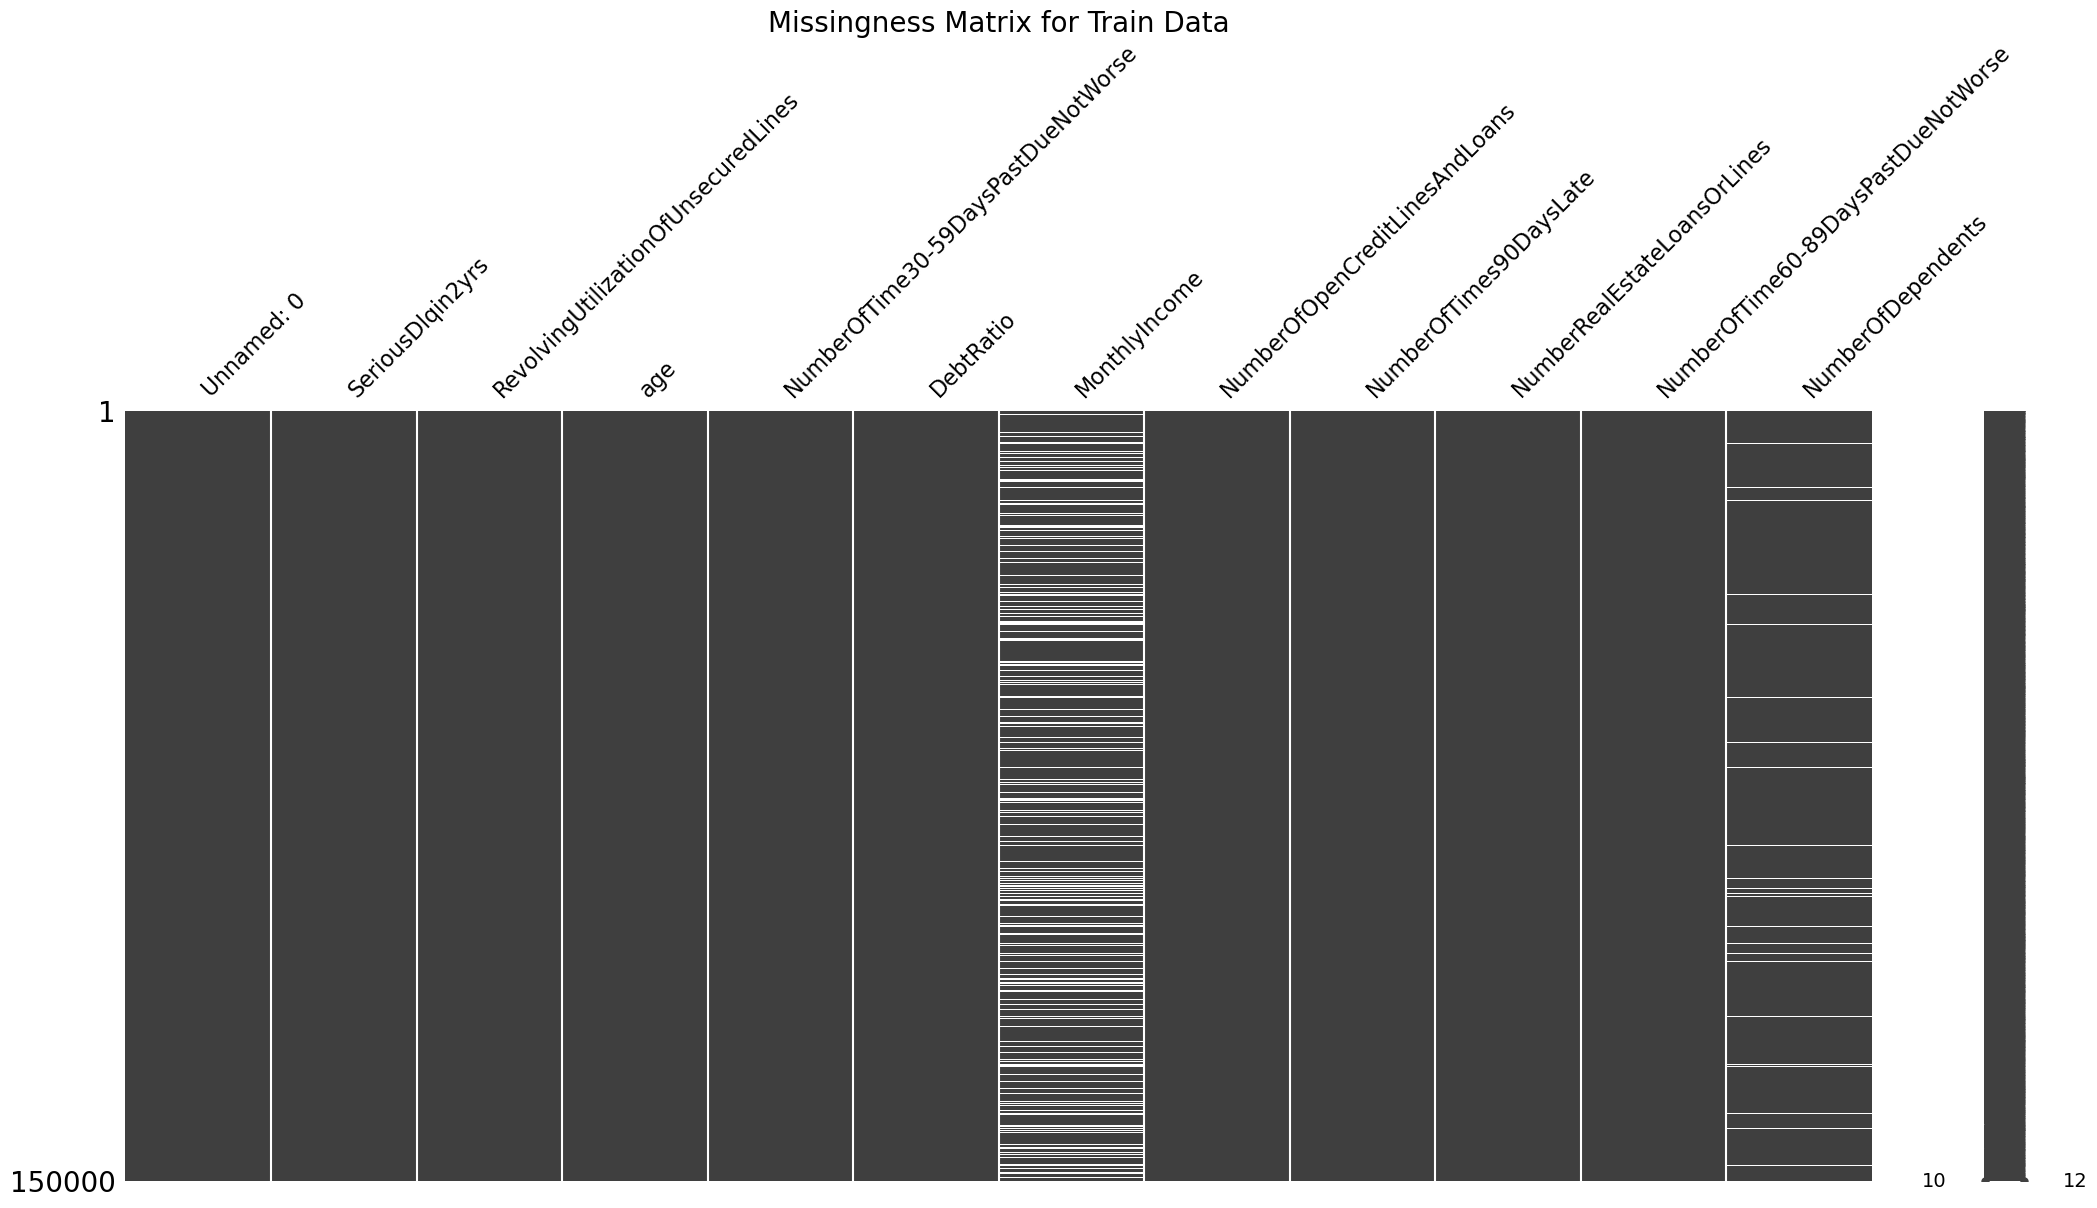

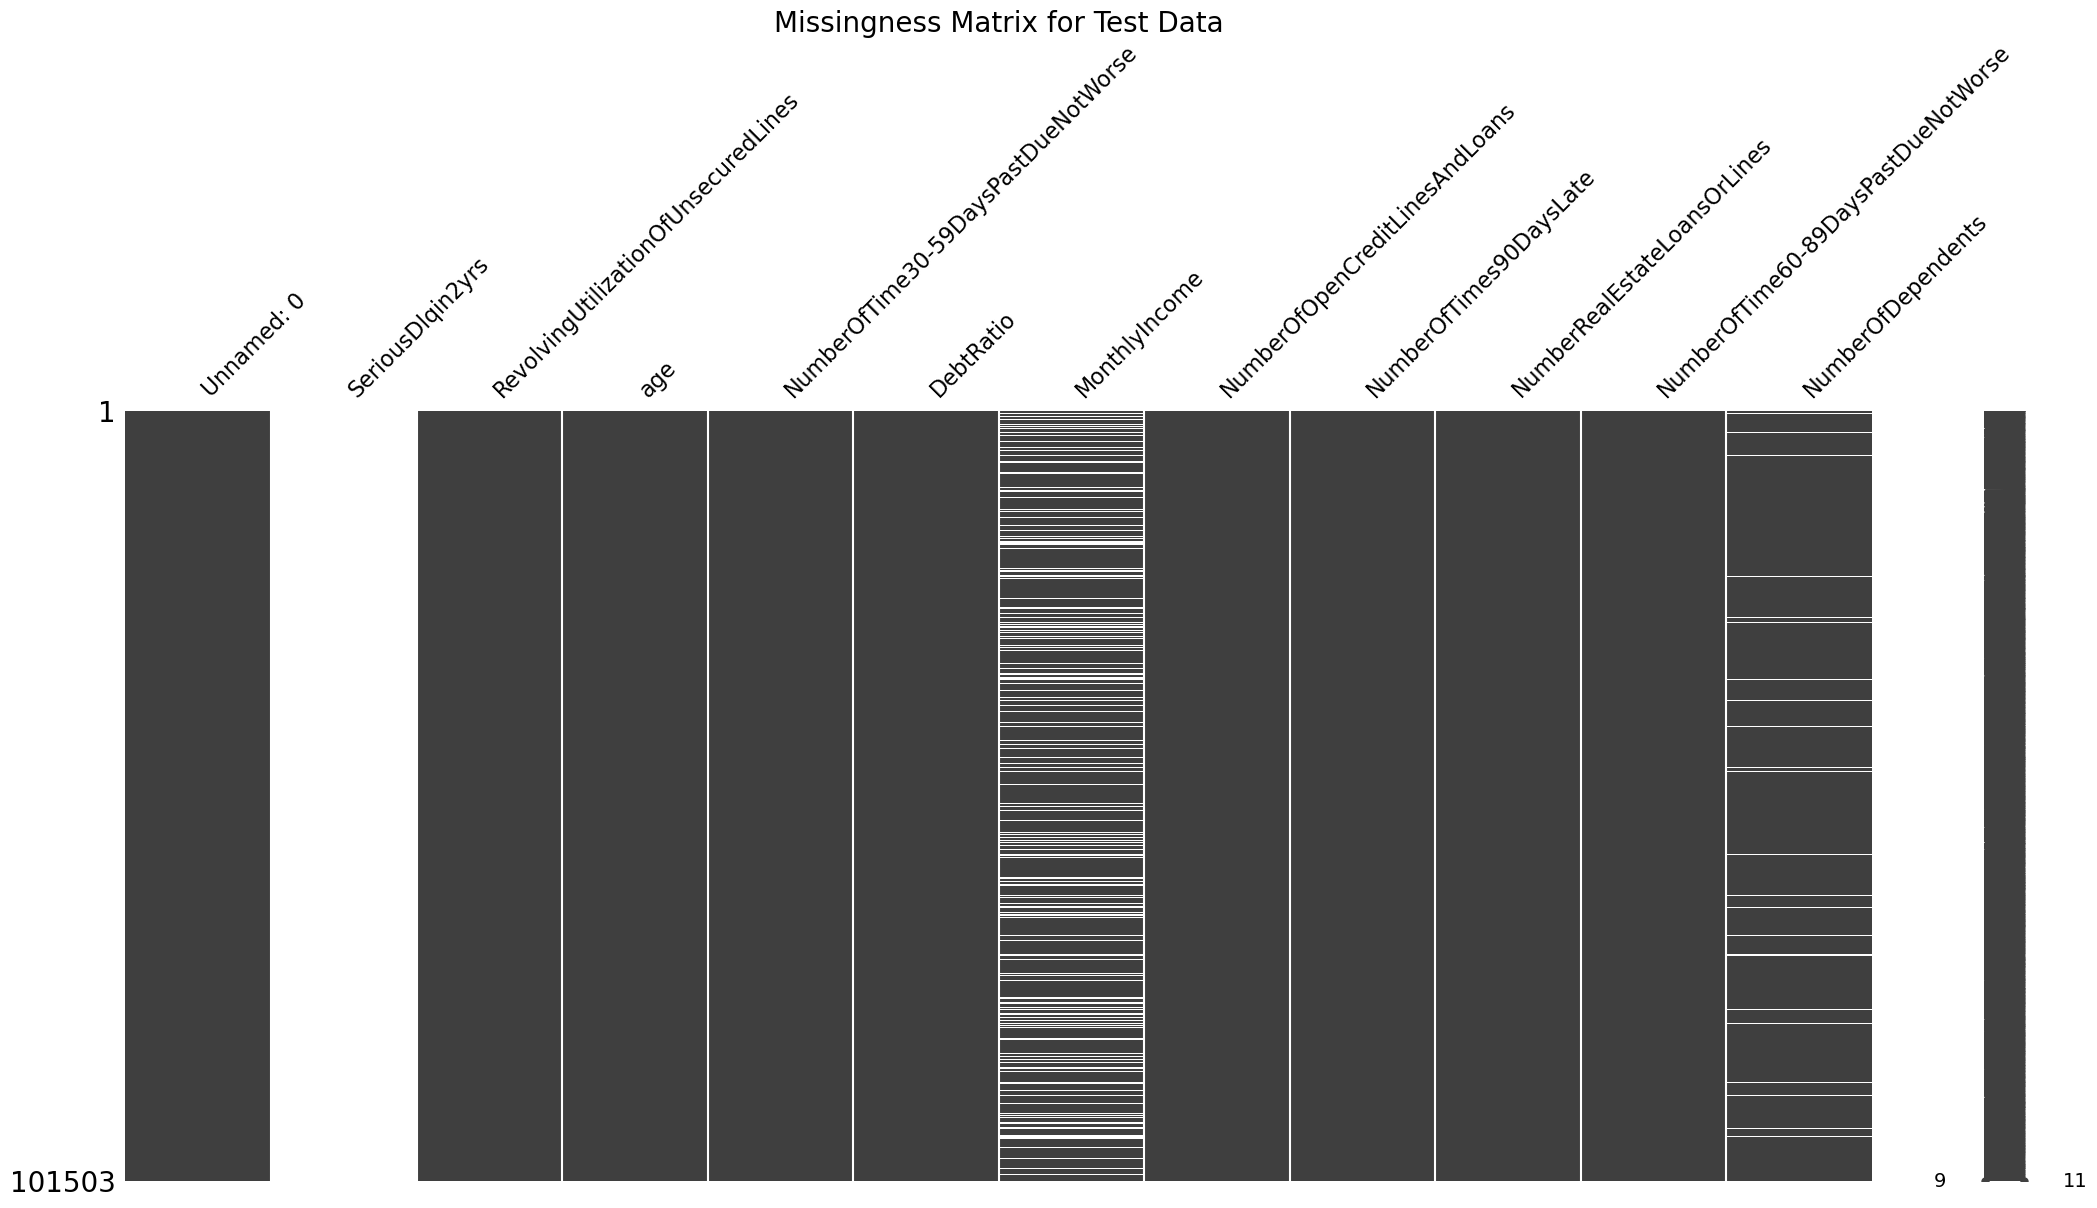

In [7]:
msno.matrix(train)
title_font = {'size': 20}  # Adjust the font size as needed
plt.title("Missingness Matrix for Train Data", fontdict=title_font)
plt.show()

msno.matrix(test)
title_font = {'size': 20}  # Adjust the font size as needed
plt.title("Missingness Matrix for Test Data", fontdict=title_font)
plt.show()

Looks like MonthlyIncome has a lot of NaN and i'm not sure why. I will try different methods of imputation later on the Modeling phase

In [8]:
print(f"Percentage of NaN - Monthly Income: {train.loc[train['MonthlyIncome'].isnull()].shape[0]/train.shape[0]}")

print(f"Percentage of NaN - Number of dependents: {train.loc[train['NumberOfDependents'].isnull()].shape[0]/train.shape[0]}")

Percentage of NaN - Monthly Income: 0.19820666666666667
Percentage of NaN - Number of dependents: 0.02616


# Data Cleaning

In [9]:
train.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.0
mean,75000.500000,0.066840,NaN,52.295207,0.421033,353.005096,6.670222e+03,8.452760,0.265973,1.018240,0.240387,NaN
std,43301.414527,0.249746,NaN,14.771866,4.192781,2037.818604,1.438467e+04,5.145951,4.169304,1.129771,4.155179,0.0
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
25%,37500.750000,0.000000,0.029861,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.0
50%,75000.500000,0.000000,0.154175,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.0
75%,112500.250000,0.000000,0.559082,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.0
max,150000.000000,1.000000,50720.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.0


## Unnamed: 0

In [10]:
train['Unnamed: 0'].head(10)

0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
Name: Unnamed: 0, dtype: int32

It's just an id column, which is useless for us

## Age

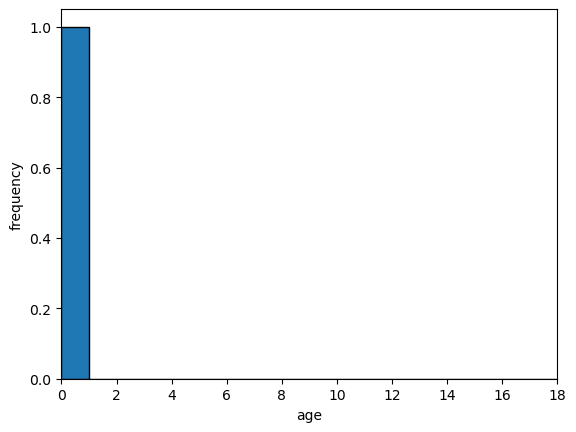

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ages = train['age']

bins = np.linspace(0, 18, 19)

plt.hist(ages, bins=bins, edgecolor='black')
plt.xlabel('age')
plt.ylabel('frequency')
plt.xlim(0, 18)
plt.show()

In [12]:
print(test['age'].describe())
print('\n\n',test[test['age'] != 0]['age'].describe())

count    101503.000000
mean         52.405436
std          14.779756
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         104.000000
Name: age, dtype: float64


 count    101503.000000
mean         52.405436
std          14.779756
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         104.000000
Name: age, dtype: float64


Looks like the min age is 21 but the max age is unsure. So, that solo 0 is an outlier, which i decided to imput as mean, since the age is not that skewed

In [13]:
# Imputing mean since data is not that skewed (age == 0 only happened once)
train.loc[train['age'] == 0,'age'] = train['age'].mean()

Evaluating multicolinearity with correlation heatmap

# Features selection

## Evaluating multicolinearity

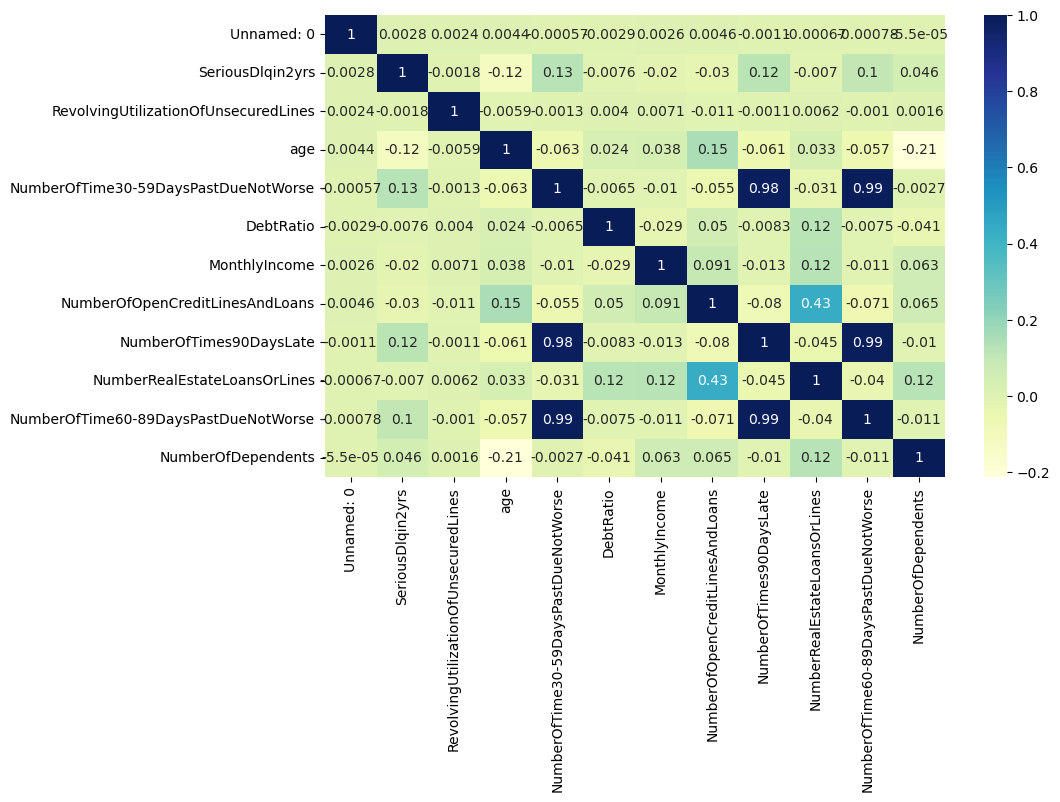

In [14]:
plt.figure(figsize=(10, 6))
# plotting correlation heatmap
dataplot = sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)

# displaying heatmap
plt.show()

Looks like we have three pairs of variables that will result in the multicolinearity problem. Let's explicitly get the pairs. I plan on removing one of the variables of the pairs that has over 0.7

In [15]:
correlation_matrix = train.corr()


multicolinearity_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            multicolinearity_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))


print('High correlation pairs:\n')            
for pair in multicolinearity_pairs:
    print(pair)

High correlation pairs:

('NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate')
('NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse')
('NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse')


I will only choose what variables will be removed after training a model and seeing the importances, even though i will probably maintain 30-59 Days since it's more related to the target

UPDATE: it seemed that removing those columns (two or one out of three that are correlated) only made it worse. It's probably due to the slightly correlation between those columns and the output

# Modeling

## Feature and target columns selection

For now i'll use every column except Unnamed: 0 in order to build the dumb and baseline model

In [16]:
feature_columns = train.drop('SeriousDlqin2yrs',axis=1).columns

In [17]:
target_column = ['SeriousDlqin2yrs']

## Imputation (selection and optimization)

Before doing baseline modeling, we have to impute the data

I first tried every imputation algorithm in sklearn and, with the accuracy, selected the best imputation (IterativeImputer). Then i did some grid search to optimize the hyperparameters

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train[feature_columns], train[target_column],
                                                    random_state=18)

## Dumb model

Dumb model: Predicting that the target will be the most frequent value

In [19]:
most_frequent_class = y_train.value_counts().idxmax()

dumb_predictions = [most_frequent_class] * len(X_test)

# Calculate accuracy
dumb_accuracy = accuracy_score(y_test, dumb_predictions)

print(f'Dumb Model Accuracy: {dumb_accuracy}')

Dumb Model Accuracy: 0.9361866666666666


In [20]:
len(X_train.columns), len(y_train.columns), len(X_test.columns), len(y_test.columns)

(11, 1, 11, 1)

The iterative imputer gave the best accuracy. Performing a grid search:

## Imputation

Finding best imputer for each model

Credit to https://www.kaggle.com/code/pouryaayria/a-complete-ml-pipeline-tutorial-acu-86, i made some changes to his functions but the main goal here is to determine the best imputers and scalers for each model

In [21]:
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'roc_auc'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs = -1)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

def GetScaledModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()
    elif nameOfScaler == 'robust':
        scaler = RobustScaler()

    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression())])))
    pipelines.append((nameOfScaler+'LDA' , Pipeline([('Scaler', scaler),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    #pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVC())])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesClassifier())])  ))
    pipelines.append((nameOfScaler+'XGB'  , Pipeline([('Scaler', scaler),('XGB'  , XGBClassifier())])  ))


    return pipelines 

def GetImputerModel(nameOfImputer):
    
    if nameOfImputer == 'mean':
        imputer = SimpleImputer(strategy='mean')
    elif nameOfImputer == 'median':
        imputer = SimpleImputer(strategy='median')
    elif nameOfImputer =='knn':
        imputer = KNNImputer()
    elif nameOfImputer == 'iterative':
        imputer = IterativeImputer()

    pipelines = []
    pipelines.append((nameOfImputer+'LR'  , Pipeline([('Imputer', imputer),('LR'  , LogisticRegression(solver = 'lbfgs',max_iter = 1000))])))
    pipelines.append((nameOfImputer+'LDA' , Pipeline([('Imputer', imputer),('LDA' , LinearDiscriminantAnalysis())])))
    pipelines.append((nameOfImputer+'KNN' , Pipeline([('Imputer', imputer),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfImputer+'CART', Pipeline([('Imputer', imputer),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfImputer+'NB'  , Pipeline([('Imputer', imputer),('NB'  , GaussianNB())])))
    #pipelines.append((nameOfimputer+'SVM' , Pipeline([('Imputer', imputer),('SVM' , SVC())])))
    pipelines.append((nameOfImputer+'AB'  , Pipeline([('Imputer', imputer),('AB'  , AdaBoostClassifier())])  ))
    pipelines.append((nameOfImputer+'GBM' , Pipeline([('Imputer', imputer),('GMB' , GradientBoostingClassifier())])  ))
    pipelines.append((nameOfImputer+'RF'  , Pipeline([('Imputer', imputer),('RF'  , RandomForestClassifier())])  ))
    pipelines.append((nameOfImputer+'ET'  , Pipeline([('Imputer', imputer),('ET'  , ExtraTreesClassifier())])  ))
    pipelines.append((nameOfImputer+'XGB'  , Pipeline([('Imputer', imputer),('XGB'  , XGBClassifier())])  ))

    return pipelines 

def ScoreDataFrame(names,results):
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

In order to get the best for each model, run the following code:

In [22]:
# compareImputer = pd.DataFrame()
# for imputer in ['mean', 'median', 'knn', 'iterative']:
#     models = GetImputerModel(imputer)
#     names,results = BasedLine2(X_train, y_train.iloc[:, 0].ravel(),models)
#     imputerScore = ScoreDataFrame(names,results)
#     compareImputer = pd.concat([compareImputer, imputerScore], ignore_index=True)

You will get an output such as

In [23]:
# Score ranking:
#               Model   Score
# 24         knnGBM  0.9364
# 33   iterativeGBM  0.9363
# 6         meanGBM  0.9363
# 15      medianGBM  0.9363
# 14       medianAB  0.9350
# 32    iterativeAB  0.9350
# 5          meanAB  0.9350
# 23          knnAB  0.9350
# 25          knnRF  0.9349
# 34    iterativeRF  0.9346
# 7          meanRF  0.9346
# 16       medianRF  0.9346
# 19         knnLDA  0.9330
# 1         meanLDA  0.9330
# 10      medianLDA  0.9330
# 28   iterativeLDA  0.9330
# 17       medianET  0.9327
# 35    iterativeET  0.9327
# 26          knnET  0.9326
# 8          meanET  0.9326
# 27    iterativeLR  0.9323
# 0          meanLR  0.9323
# 9        medianLR  0.9323
# 18          knnLR  0.9323
# 22          knnNB  0.9317
# 13       medianNB  0.9317
# 31    iterativeNB  0.9317
# 4          meanNB  0.9317
# 20         knnknn  0.9306
# 11      medianKNN  0.9306
# 29   iterativeKNN  0.9306
# 2         meanKNN  0.9306
# 30  iterativeCART  0.8980
# 21        knnCART  0.8978
# 3        meanCART  0.8976
# 12     medianCART  0.8975

To build a more visual dataframe, you can separate Imputer and Model:

In [24]:
# compareModels['Imputer'] = compareModels['Model'].str.extract(r'([a-z]+)')[0]
# compareModels['Model'] = compareModels['Model'].str.extract(r'([A-Z]+)')[0]

## Baseline model

As seen before, the baseline accuracy is 0.93744

In [25]:
imputer = KNNImputer()
train_imputed = imputer.fit_transform(X_train)
test_imputed = imputer.transform(X_test)
model = RandomForestClassifier()

model.fit(train_imputed, y_train)
predictions = model.predict(test_imputed)
accuracy = accuracy_score(y_test, predictions)

print('Accuracy score: ', accuracy)

/tmp/ipykernel_21/1452138335.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_imputed, y_train)


Accuracy score:  0.9382933333333333


## Scaling numerical features

Similar to imputation, finding the best scaler

In [26]:
compareScalers = pd.DataFrame()
for scaler in ['standard', 'minmax', 'robust']:
    models = GetScaledModel(scaler)
    names,results = BasedLine2(X_train, y_train.iloc[:, 0].ravel(),models)
    scalerScore = ScoreDataFrame(names,results)
    compareScalers = pd.concat([compareScalers, scalerScore], ignore_index=True)

In [27]:
# compareScalers['Scaler'] = compareScalers['Model'].str.extract(r'([a-z]+)')[0]
# compareScalers['Model'] = compareScalers['Model'].str.extract(r'([A-Z]+)')[0]

In [28]:
print('Score ranking:\n ', compareScalers.sort_values(by="Score",ascending=False),'\n')
print('Best Scaler for each model: \n')
best_indices = compareScalers.groupby('Model')['Score'].idxmax()
best_scaler_and_score = compareScalers.loc[best_indices, ['Model', 'Scaler', 'Score']]
print(best_scaler_and_score.reset_index(drop=True))

You will get an output such as:

In [29]:
# Score ranking:
#      Model   Score    Scaler
# 24   GBM  0.9363  standard
# 15   GBM  0.9363    robust
# 6    GBM  0.9361    minmax
# 14    AB  0.9350    robust
# 23    AB  0.9348  standard
# 16    RF  0.9347    robust
# 5     AB  0.9346    minmax
# 7     RF  0.9346    minmax
# 25    RF  0.9343  standard
# 19   LDA  0.9330  standard
# 10   LDA  0.9330    robust
# 18    LR  0.9330  standard
# 1    LDA  0.9330    minmax
# 17    ET  0.9327    robust
# 26    ET  0.9325  standard
# 8     ET  0.9325    minmax
# 0     LR  0.9324    minmax
# 2    KNN  0.9323    minmax
# 9     LR  0.9322    robust
# 20   KNN  0.9315  standard
# 13    NB  0.9314    robust
# 22    NB  0.9313  standard
# 4     NB  0.9313    minmax
# 11   KNN  0.9311    robust
# 12  CART  0.8977    robust
# 21  CART  0.8972  standard
# 3   CART  0.8946    minmax 

# Best Scaler for each model: 

#   Model    Scaler   Score
# 0    AB    robust  0.9350
# 1  CART    robust  0.8977
# 2    ET    robust  0.9327
# 3   GBM    robust  0.9363
# 4   KNN    minmax  0.9323
# 5   LDA    minmax  0.9330
# 6    LR  standard  0.9330
# 7    NB    robust  0.9314
# 8    RF    robust  0.9347

Difference between different scaling is not that significant, but still worth trying

# Hyperparameter tunning

I'm commentating over my code since it takes a lot of time (if you want to reduce it, just lower the cv). I haven't found a way to skip some cells in kaggle runcode, so i will keep it like that. Feel free to test and see the results on your own

## LogisticRegression

In [30]:
models = [LogisticRegression()]

param_grids = {
    'C': Real(0.01, 4.0, prior='log-uniform'),
    'penalty': Categorical(['l2', 'none']) 
}

clf1 = BayesSearchCV(
    LogisticRegression(),
    param_grids,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    n_iter=32,
    verbose=2,
    random_state=42
)

warnings.filterwarnings("ignore", category=DeprecationWarning)
clf1.fit(train_imputed, y_train)

message = (clf1.best_score_, clf1.best_params_)
print("Best: %f using %s" % message)

# results = clf1.cv_results_
# for i, (params, score) in enumerate(zip(results['params'], results['mean_test_score'])):
#     print(f"Iteration {i + 1}: Hyperparameters: {params}, Score: {score}")


## KNeighborsClassifier

In [31]:
models = [LogisticRegression()]

param_grids = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}

clf2 = BayesSearchCV(
    KNeighborsClassifier(),
    param_grids,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    n_iter=32,
    verbose=2,
    random_state=42
)

warnings.filterwarnings("ignore", category=DeprecationWarning)
clf2.fit(train_imputed, y_train)

message = (clf2.best_score_, clf2.best_params_)
print("Best: %f using %s" % message)

In [32]:
results = clf2.cv_results_
for i, (params, score) in enumerate(zip(results['params'], results['mean_test_score'])):
    print(f"Iteration {i + 1}: Hyperparameters: {params}, Score: {score}")

## DecisionTreeClassifier

In [33]:
param = {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 3}
# model4 = DecisionTreeClassifier(**param)

models = [DecisionTreeClassifier()]

param_grid = {
    'criterion': ["gini", "entropy"],
    'max_depth': [3, None],
    'max_features': randint(1, 4),
    'min_samples_leaf': randint(1, 4)
}

clf3 = RandomizedSearchCV(
    DecisionTreeClassifier(),
    param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    n_iter=32,
    verbose=2,
    random_state=42
)

warnings.filterwarnings("ignore", category=DeprecationWarning)
clf3.fit(train_imputed, y_train)

message = (clf3.best_score_, clf3.best_params_)
print("Best: %f using %s" % message)

In [34]:
results = clf3.cv_results_
for i, (params, score) in enumerate(zip(results['params'], results['mean_test_score'])):
    print(f"Iteration {i + 1}: Hyperparameters: {params}, Score: {score}")

## AdaBoostClassifier

In [35]:
# Define the parameter grid for AdaBoostClassifier
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'n_estimators': [50, 100, 150, 200, 250, 300]
}

# Create an AdaBoostClassifier instance
model = AdaBoostClassifier()

# Create a RandomizedSearchCV instance for AdaBoostClassifier
clf4 = RandomizedSearchCV(
    model,
    param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    n_iter=32,
    verbose=10,
    random_state=42
)

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Fit the model
clf4.fit(train_imputed.head(100), y_train.head(100))

# Get the best score and parameters
message = (clf4.best_score_, clf4.best_params_)
print("Best: %f using %s" % message)



In [36]:
for i in range(len(clf3.cv_results_['params'])):
    print(f"Iteração {i + 1}:")
    print(f"Parâmetros: {random_search.cv_results_['params'][i]}")
    print(f"Pontuação média: {random_search.cv_results_['mean_test_score'][i]}")
    print(f"Desvio padrão: {random_search.cv_results_['std_test_score'][i]}")
    print()

## GradientBoostingClassifier

In [37]:
param_grid = {
    'learning_rate': [.01,.05,.1,.5,1],
    'n_estimators': [50,100,150,200,250,300]
}

# Create an AdaBoostClassifier instance
model = GradientBoostingClassifier()

# Create a RandomizedSearchCV instance for AdaBoostClassifier
clf5 = RandomizedSearchCV(
    model,
    param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    n_iter=32,
    verbose=1,
    random_state=42
)

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Fit the model
clf5.fit(train_imputed, y_train)

# Get the best score and parameters
message = (clf5.best_score_, clf5.best_params_)
print("Best: %f using %s" % message)

## Random Forest Classifier

In [38]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

model = RandomForestClassifier()

# Create a RandomizedSearchCV instance for AdaBoostClassifier
clf6 = RandomizedSearchCV(
    model,
    param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    n_iter=32,
    verbose=1,
    random_state=42
)

# Fit the model
clf6.fit(train_imputed, y_train)

# Get the best score and parameters
message = (clf6.best_score_, clf6.best_params_)
print("Best: %f using %s" % message)

## GaussianNB

In [39]:
# Define the parameter grid (There are no hyperparameters for GaussianNB)
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Create a GaussianNB instance
model = GaussianNB()

# Create a RandomizedSearchCV instance for GaussianNB
clf6 = RandomizedSearchCV(  # Change clf to clf6
    model,
    param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    n_iter=5,  # Adjust the number of iterations as needed
    verbose=1,
    random_state=42
)

# Fit the model
clf6.fit(train_imputed, y_train)

# Get the best score and parameters
message = (clf6.best_score_, clf6.best_params_)
print("Best: %f using %s" % message)

## ExtraTreesClassifier

In [40]:
# Define the parameter grid for ExtraTreesClassifier
param_grid = {
    'n_estimators': [100, 200, 300, 1000],
    'max_depth': [80, 90, 100, 110],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [3, 4, 5],
    'max_features': [2, 3],
    'bootstrap': [True]
}

# Create an ExtraTreesClassifier instance
model = ExtraTreesClassifier()

# Create a RandomizedSearchCV instance for ExtraTreesClassifier
clf7 = RandomizedSearchCV(
    model,
    param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    n_iter=32,  # Adjust the number of iterations as needed
    verbose=1,
    random_state=42
)

# Fit the model
clf7.fit(train_imputed, y_train)

# Get the best score and parameters
message = (clf7.best_score_, clf7.best_params_)
print("Best: %f using %s" % message)

## XGBClassifier

In [41]:
# Define the parameter grid for ExtraTreesClassifier
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

# Create an ExtraTreesClassifier instance
model = XGBClassifier()

# Create a RandomizedSearchCV instance for ExtraTreesClassifier
xgb = RandomizedSearchCV(
    model,
    param_grid,
    scoring='roc_auc',
    cv=10,
    n_jobs=-1,
    n_iter=32,  # Adjust the number of iterations as needed
    verbose=1,
    random_state=42
)

# Fit the model
xgb.fit(train_imputed, y_train)

# Get the best score and parameters
message = (xgb.best_score_, xgb.best_params_)
print("Best: %f using %s" % message)

# Ensemble Voting

I found doing the scoring manually instead of straight using the VotingClassifier fundamental. With that, we can keep changing weights manually in order to find the best combination. In addition, we can also add one more model without having to refitting everything again.



I actually got a significant improvement from changing weights (went from top 70 to top 30)

In [42]:
xgb_model = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('xgb', XGBClassifier(subsample=1, min_child_weight=10, max_depth=3, gamma=1.5, colsample_bytree=1))
])

randomForest = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', KNNImputer()),
    ('RF', RandomForestClassifier(n_estimators=200, min_samples_split=12, min_samples_leaf=5,
                                  max_features=2, max_depth=80, bootstrap=True, n_jobs=-1))
])

gbm = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', KNNImputer()),
    ('GBM', GradientBoostingClassifier(n_estimators=250, learning_rate = 0.1))
])

extraTree = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('ET', ExtraTreesClassifier(n_estimators=1000, min_samples_split=8, min_samples_leaf=5,
                                  max_features=3, max_depth=90, bootstrap=True))
])
adaBoost = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('AB', AdaBoostClassifier(n_estimators=100, learning_rate = 0.01))
])

estimators = [
    ('xgb', xgb_model),  
    ('rf', randomForest),
    ('gbm', gbm),
    ('et', extraTree),
    ('ab', adaBoost)
]

ensemble_5_models = VotingClassifier(estimators, voting='soft', verbose=10)
#probas = [c.fit(X, y).predict_proba(X) for c in estimators]


ensemble_5_models.fit(train.drop(['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1), train['SeriousDlqin2yrs'])

individual_model_predictions = [estimator.predict_proba(test.drop(['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1)) for estimator in ensemble_5_models.estimators_]

weights = [9, 7, 5, 4, 1]
weighted_predictions = sum(weight * prediction[:, 1] for weight, prediction in zip(weights, individual_model_predictions)) / sum(weights)
#predictions = ensemble_5_models.predict_proba(test.drop(['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1))

[Voting] ...................... (1 of 5) Processing xgb, total=   4.6s


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[Voting] ....................... (2 of 5) Processing rf, total= 6.0min
[Voting] ...................... (3 of 5) Processing gbm, total= 6.7min
[Voting] ....................... (4 of 5) Processing et, total= 1.4min
[Voting] ....................... (5 of 5) Processing ab, total=  17.8s


In [43]:
import joblib
joblib.dump(ensemble_5_models, 'ensemble_5_models.pkl')

['ensemble_5_models.pkl']

# SuperLearner attempt

It didnt improve the score

In [44]:
from sklearn.ensemble import StackingClassifier
xgb_model = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('xgb', XGBClassifier(subsample=1, min_child_weight=10, max_depth=3, gamma=1.5, colsample_bytree=1))
])

randomForest = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', KNNImputer()),
    ('RF', RandomForestClassifier(n_estimators=200, min_samples_split=12, min_samples_leaf=5,
                                  max_features=2, max_depth=80, bootstrap=True, n_jobs=-1))
])

gbm = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', KNNImputer()),
    ('GBM', GradientBoostingClassifier(n_estimators=250, learning_rate=0.1))
])

extraTree = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('ET', ExtraTreesClassifier(n_estimators=1000, min_samples_split=8, min_samples_leaf=5,
                                max_features=3, max_depth=90, bootstrap=True))
])

adaBoost = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('AB', AdaBoostClassifier(n_estimators=100, learning_rate=0.01))
])

# Create a list of base models
base_models = [
    ('xgb', xgb_model),
    ('rf', randomForest),
    ('gbm', gbm),
    ('et', extraTree),
    ('ab', adaBoost)
]

# Define XGBClassifier as the super learner (final estimator)
super_learner = XGBClassifier(subsample=1, min_child_weight=10, max_depth=3, gamma=1.5, colsample_bytree=1)

# Create the stacking classifier
stacking_classifier = StackingClassifier(
    estimators=base_models,
    final_estimator=super_learner,
    cv=5,  # You can adjust the number of cross-validation folds as needed
    verbose = 2
)

# Train the stacking classifier on your data
stacking_classifier.fit(train.drop(['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1), train['SeriousDlqin2yrs'])

print('Done fitting')
# Make predictions using the stacking classifier
stacking_predictions = [estimator.predict_proba(test.drop(['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1)) for estimator in stacking_classifier.named_estimators_.values()]


In [45]:
# weights = [9, 7, 5, 4, 1]
# weighted_predictions_super = sum(weight * prediction[:, 1] for weight, prediction in zip(weights, stacking_predictions)) / sum(weights)

In [46]:
# joblib.dump(stacking_classifier, 'stacking_classifier.pkl')

# Submission

In [47]:
submission = pd.DataFrame({'Id': test['Unnamed: 0'], 'Probability': weighted_predictions})
submission.index = submission['Id']
submission.drop('Id',axis=1,inplace=True)
submission.to_csv('submission.csv')

# Example of adding another model to the voting

In [48]:
knn = Pipeline([
    ('scaler', MinMaxScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('KNN', KNeighborsClassifier(n_neighbors = 20, n_jobs = -1))
])

knn.fit(train.drop(['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1), train['SeriousDlqin2yrs'])

knn_predictions = knn.predict_proba(test.drop(['Unnamed: 0', 'SeriousDlqin2yrs'], axis=1))


In [49]:
new_predictions = individual_model_predictions
new_weights = weights
new_predictions.append(knn_predictions)
new_weights.append(1)

So you can do the weights again

In [50]:
new_weighted_predictions = sum(weight * prediction[:, 1] for weight, prediction in zip(new_weights, new_predictions)) / sum(weights)